# Stiff coupling

Depending on the charasteristics of the coupling between each submodels, there may be instances where the explicit coupling is higly inefficient and suffers from a tendency to be come unstable. In this tutorial, we explore this issue.

## Toy model : dual spring mass
We take the toy model from the previous notebooks, which models the dynamics of two mass-spring systems linked in series. A sketch of the system is given in Figure 1.

<!--- ![sketch](sketch_springmass.png "Figure 1 - Sketch of the system") -->
<img src="sketch_springmass.png" alt="sketch" width="500"/>
Both bodies have equal mass, and both springs have the same stiffness $k$.

The system dynamics are governed by the following equations :
\begin{equation}
    \begin{cases}
        m \ddot{x_1} &=  &k_c (x_2 - x_1) - k_1 x_1 \\
        m \ddot{x_2} &= -&k_c (x_2 - x_1) + k_2(1-x_2)
    \end{cases}
\end{equation}

In the first notebook, we have implemented a partionned approach for the case where $k_1=k_2=k_c$ and $m_1=m_2$. The following code implements a variant of this approach with the ability to use different values for each of these variables.

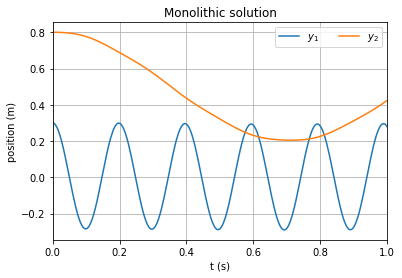

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from rhapsopy.coupling import Orchestrator
from rhapsopy.accelerators import NewtonSolver, DampedNewtonSolver, IQNSolver, AitkenUnderrelaxationSolver, AitkenScalarSolver, FixedPointSolver, AndersonSolver, ExplicitSolver

k1=1000.
m1=1.
k2=10.
m2=1.
kc = 10.
y0_global = np.array([0.3, 0, 0.8, 0])
tf = 1.

A=np.array(((0.,1,0,0),
            (-(k1+kc)/m1,0,kc/m1,0),
            (0,0,0,1),
            (kc/m2,0,-(kc+k2)/m2,0)))
b = np.array((0.,0,0,k2/m2))
def coupled_ode(t,y):
    return A @ y + b

# monolithic approach
sol = solve_ivp(fun=coupled_ode,
                y0=y0_global, t_span=[0.,10.],
                method='LSODA', atol=1e-6, rtol=1e-6)

from scipy.optimize import OptimizeResult as OdeResult
def rk_44( fun, t_span, y0, nt):
    """RK (4,4)
        source: https://josselin.massot.gitlab.labos.polytechnique.fr/ponio/viewer.html#rk_44
    """
    un = y0.copy()
    dt = (t_span[1]-t_span[0])/nt
    tn = t_span[0]
    thist = [t_span[0]]
    uhist = [y0]
    for i in range(nt):
        ## RK4
        #k1 = fun(tn, un)
        #k2 = fun(dt/2 + tn, dt*k1/2 + un)
        #k3 = fun(dt/2 + tn, dt*k2/2 + un)
        #k4 = fun(dt + tn, dt*k3 + un)
        #un = un + dt*(k1/6 + k2/3 + k3/3 + k4/6)
        ## Explicit midpoint
        k1 = fun(tn,un)
        k2 = fun(tn+dt/2, un+dt/2*k1)
        un = un + dt*k2
        
        tn = tn + dt
        thist.append(tn)
        uhist.append(un)
        
    assert np.allclose(tn, t_span[1])
    out = OdeResult()
    out.t = np.array(thist)
    out.y = np.array(uhist).T
    
    if 0: #max(abs(un[0,:]))>1e1: # divergence of body position
        out.success = False
        out.message = 'instability in subsystem integration'
    else:
        out.success = True
        out.message = "success with RK4"
    return out

def odefun_single(t,x,isolv,inputs):
    # x = [position, speed]
    dxdt = np.zeros((2,))
    dxdt[0] = x[1]
    if isolv==0:
        dxdt[1] = -(k1+kc)/m1*(x[0]-inputs['xim1'](t)) + kc/m1 * inputs['xip1'](t)
    else:
        dxdt[1] = -(kc+k2)/m2*x[0] + kc/m2 * inputs['xim1'](t) + k2/m2*inputs['xip1'](t)
    return dxdt

from rhapsopy.coupling import BaseCoupler
class SpringMassCoupler(BaseCoupler):
    def __init__(self,k1,k2,kc,m1,m2):
        self.k1, self.k2, self.kc = k1, k2, kc
        self.m1, self.m2 = m1, m2
        self.nCouplingVars = 2 # we have 2 coupling variables: the positions of both masses
        self.nSubsystems   = 2 # we have 2 coupled subsystems
        
    def getCouplingVars(self,t,y):
        """ Return the coupling variables, which are simply the speed and positions of the nodes """
        return y[::2]

    def integrateSingleSubsystem(self, isolv, t0, y0, dt, preds, rtol=None, bDebug=False):
        """ Performs one iteration of a code coupling step (Jacobi or Gauss-Seidel)
              --> computes the value of the overall state vector at time t+dt,
                  starting from state y at time t. """
        # get each subsystem's state vector
        y0_subsystems = [y0[2*i:2*(i+1)] for i in range(2)]
        
        # Distribute the predictions
        current_input = {}
        if isolv==0: # first mass
            current_input['xim1'] = lambda t: 0. # left attachment point
            current_input['xip1'] = lambda t: preds[1].evaluate(t)
        else: # second mass
            current_input['xim1'] = lambda t: preds[0].evaluate(t)
            current_input['xip1'] = lambda t: 1. # right attachment point
            
        # perform time integration
        fun = lambda t,y : odefun_single(t, y, isolv=isolv, inputs=current_input)
        
        if 1: # adaptive subsolve
            if rtol is None: rtol=1e-6
            atol = rtol
            current_out = solve_ivp(fun=fun,
                                    y0=y0_subsystems[isolv], t_span=[t0,t0+dt],
                                    max_step=dt, first_step=dt/2, #TODO: sometimes first_step=dt raises issues in Scipy
                                    method='RK23', atol=atol, rtol=rtol)
        else:
            current_out = rk_44( fun=fun, t_span=[t0,t0+dt], y0=y0_subsystems[isolv], nt=1)
                  
        if not current_out.success:
            raise Exception(current_out.message)
        return current_out
    
# Solve monolithically
sol = solve_ivp(fun=coupled_ode,
                y0=y0_global, t_span=[0.,tf],
                method='LSODA', atol=1e-6, rtol=1e-6)

plt.figure()
plt.plot(sol.t, sol.y[0,:], color='tab:blue', label=r'$y_1$')
plt.plot(sol.t, sol.y[2,:], color='tab:orange', label=r'$y_2$')
#plt.ylim(0,1)
plt.legend(ncol=2)
plt.grid(); plt.autoscale(enable=True, axis='x', tight=True)
plt.xlabel('t (s)')
plt.ylabel('position (m)')
plt.title('Monolithic solution');

In the first notebook, the coupled integration result looked very good, however we used a lot of coupling steps. What happens if we take fewer steps ? Let us investigate:

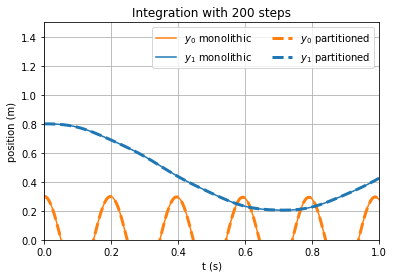

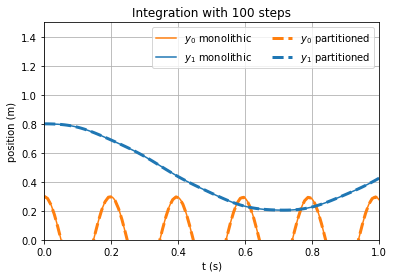

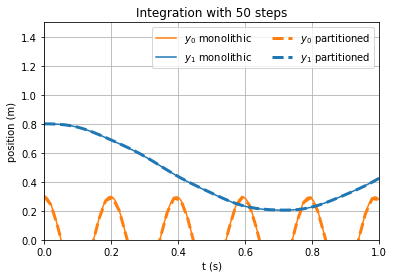

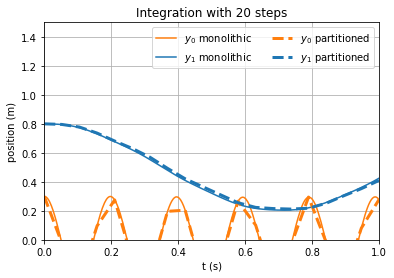

In [10]:
coupler = SpringMassCoupler(k1=k1,k2=k2,kc=kc,m1=m1,m2=m2)

conductor = Orchestrator(coupler=coupler, order=3)
conductor.interfaceSolver = ExplicitSolver

for nt in [200, 100, 50, 20]:
    solcoupled = conductor.basic_integration(y0=y0_global, t_vec=np.linspace(0,tf,nt))

    plt.figure()
    plt.plot(sol.t, sol.y[0,:], color='tab:orange', label=r'$y_0$ monolithic')
    plt.plot(sol.t, sol.y[2,:], color='tab:blue', label=r'$y_1$ monolithic')
    plt.plot(solcoupled.t, solcoupled.y[0,:], color='tab:orange', linestyle='--', linewidth=3, label=r'$y_0$ partitioned')
    plt.plot(solcoupled.t, solcoupled.y[2,:], color='tab:blue', linestyle='--', linewidth=3, label=r'$y_1$ partitioned')
    #plt.ylim(0,1)
    plt.legend(ncol=2)
    plt.grid(); plt.autoscale(enable=True, axis='x', tight=True)
    plt.xlabel('t (s)')
    plt.ylabel('position (m)')
    plt.ylim(0,1.5)
    plt.title(f'Integration with {nt} steps')

Lowering the number of steps degrades the solution, which may eventually blow up ! This is due to the explicit nature of the coupling we perform.

We can improve by using the implicit coupling strategy from the second tutorial:

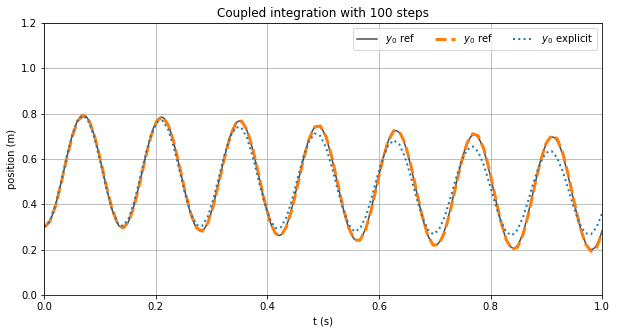

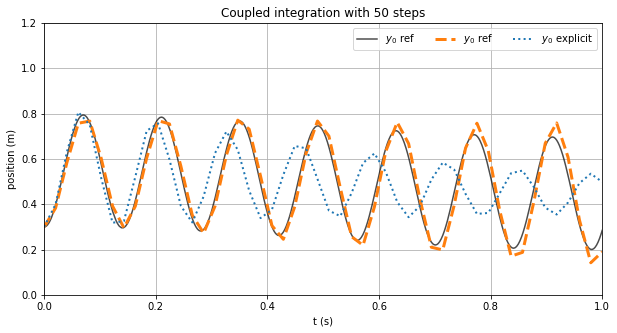

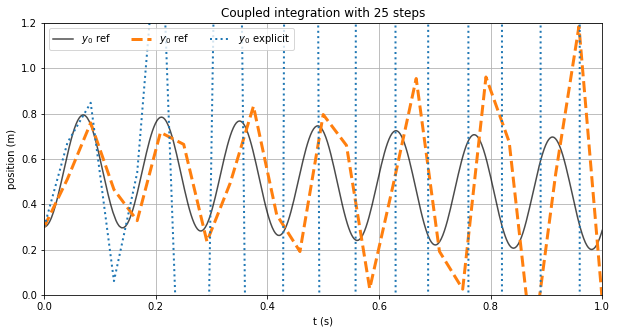

In [5]:
from rhapsopy.coupling import Orchestrator

order = 3

conductor_implicit = Orchestrator(coupler=coupler, order=order)
conductor_implicit.interfaceSolver = FixedPointSolver
conductor_implicit.waveform_tolerance = 1e-7
conductor_implicit.NITER_MAX = 1000

conductor_explicit = Orchestrator(coupler=coupler, order=order)
conductor_explicit.interfaceSolver = ExplicitSolver
conductor_explicit.NITER_MAX = 1


for nt in [100,50,25]:
    solcoupled_implicit = conductor_implicit.basic_integration(y0=y0_global, t_vec=np.linspace(0,tf,nt))
    solcoupled_explicit = conductor_explicit.basic_integration(y0=y0_global, t_vec=np.linspace(0,tf,nt))

    plt.figure(figsize=(10,5))
    plt.plot(sol.t, sol.y[0,:], color=[0,0,0], label=r'$y_0$ ref', alpha=0.7)
    plt.plot(solcoupled_implicit.t, solcoupled_implicit.y[0,:],
             color='tab:orange', linestyle='--', linewidth=3, label=r'$y_0$ ref')
    plt.plot(solcoupled_explicit.t, solcoupled_explicit.y[0,:],
             color='tab:blue', linestyle=':', linewidth=2, label=r'$y_0$ explicit')
    plt.ylim(0,1.2)
    plt.legend(ncol=3)
    plt.grid(); plt.autoscale(enable=True, axis='x', tight=True)
    plt.xlabel('t (s)')
    plt.ylabel('position (m)')
    plt.title(f'Coupled integration with {nt} steps')

This looks much better than before. However the computational cost per coupling step has increased, since we have to iterate multiple times on each step.
Here, we simply used a fixed-point algorithm to find the converged values of the coupling variables at each step. Acceleration methods are available in the literature and are being implemented. **Stay tuned !**